In [40]:
import json
import pandas as pd
import ast

# BEGIN of python-dotenv section
from os.path import join, dirname
from dotenv import load_dotenv
import os

from watson_developer_cloud import ToneAnalyzerV3

dotenv_path = join(dirname('__file__'), '.env')
load_dotenv(dotenv_path)

tone_analyzer = ToneAnalyzerV3(
   username=os.environ.get("TONE_USERNAME"),
   password=os.environ.get("TONE_PASSWORD"),
   version='2016-05-19')

In [2]:
def parse_toneanalyzer_response(json_data):
    """Parses the JSON response from ToneAnalyzer to return
    a dictionary of emotions and their corresponding score.

    Parameters
    ----------
    json_data: {dict} a json response from ToneAnalyzer (see Notes)

    Returns
    -------
    dict : a {dict} whose keys are emotion ids and values are their corresponding score.
    """
    emotion_tones = {}
    for entry in json_data['document_tone']['tone_categories']:
        if entry['category_id'] == 'emotion_tone':
            for emotion in entry['tones']:
                emotion_key = emotion['tone_name']
                emotion_value = emotion['score']
                emotion_tones[emotion_key] = emotion_value
                
    language_tones = {}
    for entry in json_data['document_tone']['tone_categories']:
        if entry['category_id'] == 'language_tone':
            for language in entry['tones']:
                language_key = language['tone_name']
                language_value = language['score']
                language_tones[language_key] = language_value
                
    social_tones = {}
    for entry in json_data['document_tone']['tone_categories']:
        if entry['category_id'] == 'social_tone':
            for social in entry['tones']:
                social_key = social['tone_name']
                social_value = social['score']
                social_tones[social_key] = social_value
                
    return emotion_tones, language_tones, social_tones
    

In [48]:
df = pd.read_csv('../data/rss_feeds_new_from_NA.csv')
df = df[pd.notnull(df['article_text'])]
df.to_csv('../data/rss_feeds_new_from_NA.csv', index=False)

In [49]:
df = pd.read_csv('../data/rss_feeds_new_from_NA.csv')
df = df[pd.notnull(df['article_text'])]
tone_df = pd.read_csv('../data/tones.csv')

sentiment_texts = []
for i in range(df.shape[0]):
    sentiment_texts.append(df['sentiment_texts'][i])
print(len(sentiment_texts))

6772


In [56]:
# idxs = df[~df['url'].isin(tone_df['url'].tolist())].index
idxs = df[df['tones'].isnull()].index

In [57]:
len(idxs)

1588

In [53]:
import numpy as np
old_tones = []
for url in df['url']:
    tone_idx = [i for i in tone_df[tone_df['url'] == url].index]
    if tone_idx != []:
        old_tones.append(tone_df['tone'][tone_idx].values)
    else:
        old_tones.append(np.nan)

In [55]:
df['tones'] = old_tones
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6772 entries, 0 to 6771
Data columns (total 11 columns):
article_text       6772 non-null object
author             6772 non-null object
date_published     6373 non-null object
headline           6772 non-null object
url                6772 non-null object
source             6772 non-null object
topic_texts        6772 non-null object
sentiment_texts    6772 non-null object
quote_texts        6174 non-null object
tweet_texts        952 non-null object
tones              5184 non-null object
dtypes: object(11)
memory usage: 954.9+ KB


In [ ]:
from dateutil import parser
from datetime import datetime, timedelta

df2 = pd.read_csv('../data/rss_feeds_new_from_NA.csv')
new_date = []
for i,date in enumerate(df2['date_published']):
    try:
        temp = parser.parse(date)
        if temp.microsecond != 0:
            new_date.append(temp - timedelta(hours=6))
        else:
            new_date.append(temp)
    except:
        print(date)
        new_date.append(date)

In [45]:
df2.groupby(df2[~df2['date_published'].isnull()]['date_published'].dt.day).count().plot(kind="bar")

AttributeError: Can only use .dt accessor with datetimelike values

In [58]:
len(new_tones)

1121

In [61]:
# new_tones = []
for i in idxs:
    try:
        json_response_sentiment = tone_analyzer.tone(text=' '.join(sentiment_texts[i]), sentences=False)
        temp = parse_toneanalyzer_response(json_response_sentiment)
        new_tones.append(temp)
        df['tones'][i] = temp
    except:
        print('Problem')

In [64]:
df.to_csv('../data/rss_feeds_with_tones2.csv', index=False)

In [61]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np

/home/ian/anaconda3/envs/cbc/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [63]:
emotion_tuple = (emotion_tones_article['Anger'], emotion_tones_article['Disgust'], emotion_tones_article['Fear'], emotion_tones_article['Joy'], emotion_tones_article['Sadness'])
X_axis_legends_tuple = ('Anger', 'Disgust', 'Fear', 'Joy', 'Sadness')

In [73]:
a = 1.0
colors = [(1, 0, 0, a), (0, 1, 0, a), (128.0/255, 0, 128.0/255, a), (1, 1, 0, a), (0, 0 , 1, a)]
n_groups = 5
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 1.0
rects1 = plt.bar(index, emotion_tuple, bar_width,
                 alpha=opacity,
                 color=colors,
                 label='Tone')
plt.xlabel('Emotional tone')
plt.ylabel('Scores')
plt.title('Emotional tones and their scores')
plt.xticks(index + bar_width, X_axis_legends_tuple)
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig('emotion_analysis')
plt.clf()

In [ ]:
tones = []
for i in range(df.shape[0]):
    json_response_sentiment = tone_analyzer.tone(text=' '.join(sentiment_texts[i]), sentences=False)
    tones.append(parse_toneanalyzer_response(json_response_sentiment))

In [96]:
anger_scores = []
disgust_scores = []
fear_scores = []
joy_scores = []
sadness_scores = []
analytical_scores = []

for i in range(len(tones)):
    if tones[i][1]['Analytical'] != 0:
        anger_scores.append(tones[i][0]['Anger'])
        disgust_scores.append(tones[i][0]['Disgust'])
        fear_scores.append(tones[i][0]['Fear'])
        joy_scores.append(tones[i][0]['Joy'])
        sadness_scores.append(tones[i][0]['Sadness'])
        analytical_scores.append(tones[i][1]['Analytical'])

Populating the interactive namespace from numpy and matplotlib


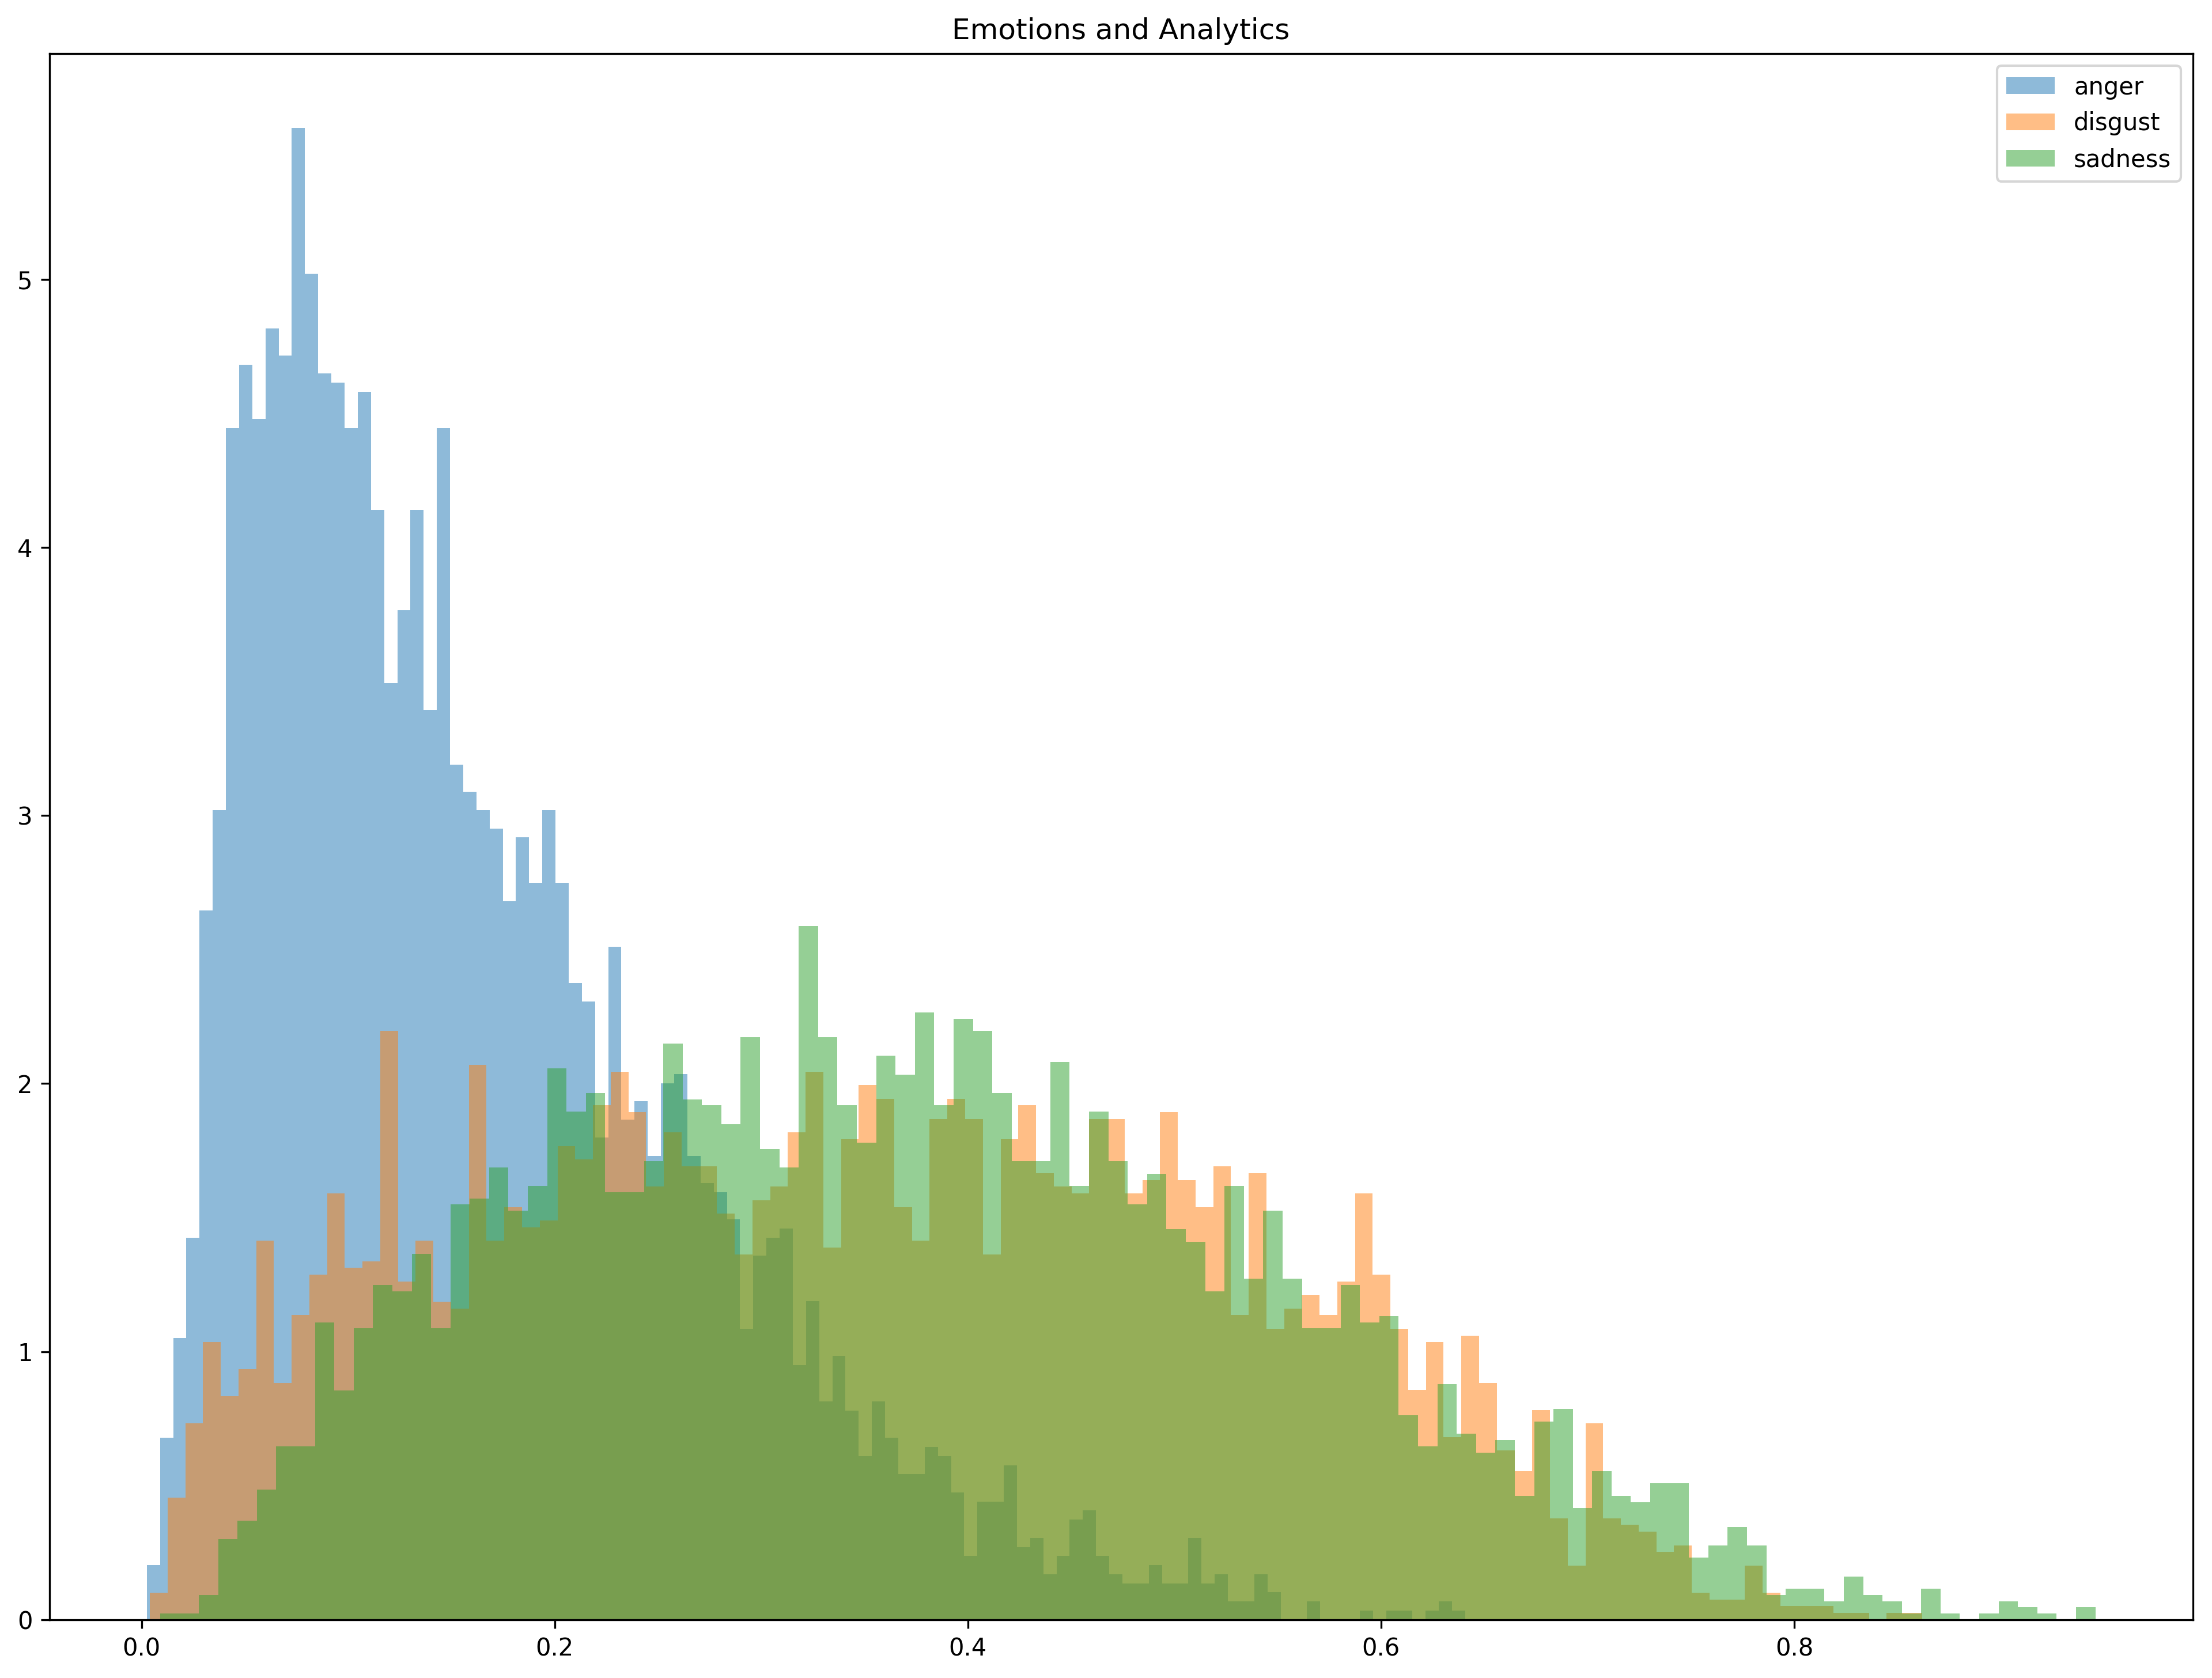

In [103]:
%pylab inline
fig1 = plt.figure(figsize=(16,12), dpi=300)
# for i in range(6):
# plt.subplot(3,2,i+1)
plt.hist(anger_scores, normed=True, alpha=0.5, bins=100, label='anger')
plt.hist(disgust_scores, normed=True, alpha=0.5, bins=100, label='disgust')
# plt.hist(fear_scores, normed=True, alpha=0.5, bins=100, label='fear')
# plt.hist(joy_scores, normed=True, alpha=0.5, bins=100, label='joy')
plt.hist(sadness_scores, normed=True, alpha=0.5, bins=100, label='sadness')
plt.title('Emotions and Analytics')
plt.legend(loc='upper right')
plt.subplots_adjust(hspace=0.4, wspace=0.4)

In [ ]:
plt.subplot(3,2,1)
plt.hist(anger_scores, normed=True, alpha=0.5, bins=100, label='anger')
plt.hist(disgust_scores, normed=True, alpha=0.5, bins=100, label='disgust')
plt.hist(fear_scores, normed=True, alpha=0.5, bins=100, label='fear')
# plt.hist(joy_scores, normed=True, alpha=0.5, bins=100, label='joy')
plt.hist(sadness_scores, normed=True, alpha=0.5, bins=100, label='sadness')
plt.title('Emotions and Analytics')
plt.legend(loc='upper right')
plt.subplots_adjust(hspace=0.4, wspace=0.4)

In [104]:
d = {'url' : df['url'], 'tone' : tones}
tone_df = pd.DataFrame(d)

In [110]:
tone_df.to_csv('tones.csv', index=False)

In [5]:
test_df = pd.read_csv('../data/tones.csv')

In [8]:
test_df['tone'][0]

"({'Anger': 0.313835, 'Disgust': 0.096521, 'Fear': 0.017036, 'Joy': 0.01762, 'Sadness': 0.0886}, {'Analytical': 0.377007, 'Confident': 0.0, 'Tentative': 0.0}, {'Openness': 0.661642, 'Conscientiousness': 0.750866, 'Extraversion': 0.854453, 'Agreeableness': 0.966137, 'Emotional Range': 0.637517})"

In [14]:
import ast
emotion_tones = []
language_tones = []
social_tones = []
for i in range(test_df.shape[0]):
    emotion_tones.append(ast.literal_eval(test_df['tone'][i])[0])
    language_tones.append(ast.literal_eval(test_df['tone'][i])[1])
    social_tones.append(ast.literal_eval(test_df['tone'][i])[2])

In [17]:
anger_tones = []
disgust_tones = []
fear_tones = []
joy_tones = []
sadness_tones = []
analytical_score = []
for i in range(len(emotion_tones)):
    anger_tones.append(emotion_tones[i]['Anger'])
    disgust_tones.append(emotion_tones[i]['Disgust'])
    fear_tones.append(emotion_tones[i]['Fear'])
    joy_tones.append(emotion_tones[i]['Joy'])
    sadness_tones.append(emotion_tones[i]['Sadness'])
    analytical_score.append(language_tones[i]['Analytical'])

In [33]:
hist_tuple = (np.mean(anger_tones), np.mean(disgust_tones), np.mean(fear_tones), np.mean(joy_tones), np.mean(sadness_tones), np.mean(analytical_score))
std = (np.std(anger_tones), np.std(disgust_tones), np.std(fear_tones), np.std(joy_tones), np.std(sadness_tones), np.std(analytical_score))
X_axis_legends_tuple = ('Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Analytical')

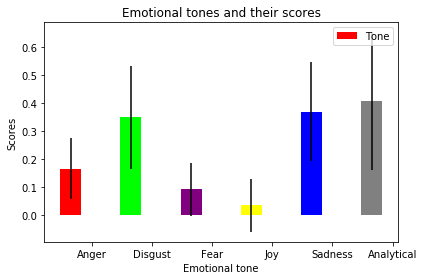

In [35]:
import matplotlib.pyplot as plt
import numpy as np
a = 1.0
colors = [(1, 0, 0, a), (0, 1, 0, a), (128.0/255, 0, 128.0/255, a), (1, 1, 0, a), (0, 0 , 1, a), (0.5,0.5,0.5,a)]
n_groups = 6
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 1.0
rects1 = plt.bar(index, hist_tuple, bar_width,
                 alpha=opacity,
                 color=colors,
                 label='Tone', yerr=std)
plt.xlabel('Emotional tone')
plt.ylabel('Scores')
plt.title('Emotional tones and their scores')
plt.xticks(index + bar_width, X_axis_legends_tuple)
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig('emotion_analysis')
plt.clf()

In [52]:
idx = np.argsort([a+b+c+d+e for a,b,c,d,e in zip(anger_tones,disgust_tones,fear_tones,joy_tones,sadness_tones)])
sorted_anger_tones = np.array(anger_tones)[idx]
sorted_disgust_tones = np.array(disgust_tones)[idx]
sorted_fear_tones = np.array(fear_tones)[idx]
sorted_joy_tones = np.array(joy_tones)[idx]
sorted_sadness_tones = np.array(sadness_tones)[idx]

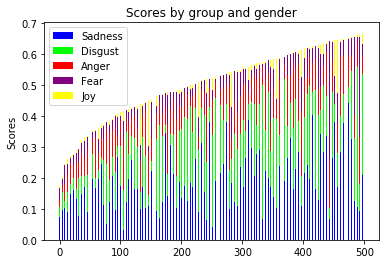

In [74]:

# N = len(anger_tones)
N = 500
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, sorted_sadness_tones[:N], width, color=colors[4])
p2 = plt.bar(ind, sorted_disgust_tones[:N], width, color=colors[1], bottom=sorted_sadness_tones[:N])
p3 = plt.bar(ind, sorted_anger_tones[:N], width, color=colors[0], bottom=sorted_sadness_tones[:N]+sorted_disgust_tones[:N])
p4 = plt.bar(ind, sorted_fear_tones[:N], width, color=colors[2], bottom=sorted_sadness_tones[:N]+sorted_disgust_tones[:N]+sorted_anger_tones[:N])
p5 = plt.bar(ind, sorted_joy_tones[:N], width, color=colors[3], bottom=sorted_sadness_tones[:N]+sorted_disgust_tones[:N]+sorted_anger_tones[:N]+sorted_fear_tones[:N])

# plt.xlim(0,1)
plt.ylabel('Scores')
plt.title('Stacked Mood Scores by Article')
# plt.xticks(ind, ('G1', 'G2', 'G3', 'G4', 'G5'))
# plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ('Sadness', 'Disgust', 'Anger', 'Fear', 'Joy'))
plt.show()

plt.savefig('../plots/multibar_plot.png')
plt.clf()